In [1]:
import pandas as pd
import os
from transformers import pipeline


/Users/sharooqsalaudeen/miniconda3/envs/ADSSThesis/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load CSV Data

# Stocks :- AAPL, MSFT, AMZN, NVDA, TSLA, GOOGL
# Sector Indices :- SSINFT (^SP500-45)


ticker = "AAPL"    
method = "DistilBERT"



In [3]:
# Load the news artcile file
#df = pd.read_csv(f"PreProcessedContextArticles/{ticker}_news_data.csv")

# Load sentiment analysis transformer
# sentiment_pipeline = pipeline("text-classification", model="distilbert-base-uncased-finetuned-sst-2-english")

In [4]:
# Due to imput size limitaiton, we need oto feed each article into the transformer and ged the sentiment score
# 3. Sentiment Analysis 
def analyze_sentiment(text):
    response = sentiment_pipeline(str(text))
    if response[0]['label'] == 'NEGATIVE':
        return -response[0]['score']
    elif response[0]['label'] == 'POSITIVE':
        return response[0]['score']
    else:
        return 0

#df['sentiment_score'] = df['Headline'].apply(analyze_sentiment)



In [5]:
# 5. Output Sentiment Results
# df.to_csv(f"SentimentAnalysis/{method}/{ticker}sentiment_output.csv", index=False)

In [6]:
# Load the HB Sentiment Results
df = pd.read_csv(f"SentimentAnalysis/{method}/{ticker}sentiment_output.csv")

In [7]:
df

,Date,Headline,Summary,sentiment_score,sentiment_label
0,2015-01-01,cnbcs biggest pops drops of,NaN,-0.945903,negative
1,2015-01-02,companies to watch as music streaming explodes,NaN,-0.999189,negative
2,2015-01-02,study only five percent of us iphone users are...,NaN,-0.975534,negative
3,2015-01-02,hearing chatter of overheating in apple iphone,NaN,-0.991982,negative
4,2015-01-02,argus expects apple to report strong q results...,NaN,-0.785084,negative
...,...,...,...,...,...
20991,2022-12-30,cnbc tv reported earlier apple is keen that c...,NaN,-0.951051,negative
20992,2022-12-30,binance ceo tweeted users can now purchase cry...,NaN,-0.995152,negative
20993,2022-12-30,investor fear eases after nasdaq rises more than,the cnn money fear and greed index showed some...,0.977554,positive
20994,2022-12-30,tesla apple ford southwest airlines hoth thera...,major wall street indices closed over higher ...,0.877049,positive


In [8]:
# 6. Aggregate the sentument score on a given day and calculate the overall sentiment by taking each days positive and negative score sum and dividing by total number of articels on that day
# Fill NaN values in the Summary column
df['Summary'].fillna("", inplace=True)

# Convert all values in 'Headline' and 'Summary' to strings
df['Headline'] = df['Headline'].astype(str)
df['Summary'] = df['Summary'].astype(str)

# Define aggregation functions
aggregations = {
    'Headline': ' '.join,
    'Summary': ' '.join,
    'sentiment_score': 'sum',
}

# Group by Date and aggregate
agg_df = df.groupby('Date').agg(aggregations).reset_index()

# Compute the average sentiment score
agg_df['polarity'] = agg_df['sentiment_score'] / df['Date'].value_counts().sort_index().values

In [9]:
agg_df

,Date,Headline,Summary,sentiment_score,polarity
0,2015-01-01,cnbcs biggest pops drops of,,-0.945903,-0.945903
1,2015-01-02,companies to watch as music streaming explodes...,,-3.751789,-0.937947
2,2015-01-03,the year of apples wearables weekly highlight...,,3.823294,0.955824
3,2015-01-05,gartner no return for tablet sales boom td ame...,,-3.988171,-0.664695
4,2015-01-06,heres why apple is giving the ces a cold shoul...,,-2.601788,-0.867263
...,...,...,...,...,...
2560,2022-12-27,these are the most popular video games of and...,was a big year for the esports industry now t...,-10.117550,-0.562086
2561,2022-12-28,amazon gets deeper in sports conceives standal...,\n\tamazoncom inc nasdaq amzn developed a stan...,-3.719431,-0.309953
2562,2022-12-29,information technology stocks with whale aler...,this whale alert can help traders discover the...,-7.653111,-0.546651
2563,2022-12-30,top wall street bets mentions for friday decem...,\n \n\taccording to counterpoints india mark...,-6.403744,-0.582159


In [10]:
# Convert the 'Date' column to datetime dtype (if it's not already)
agg_df['Date'] = pd.to_datetime(agg_df['Date'], format='%Y-%m-%d')

In [11]:
# Sort the DataFrame by the 'Date' column
agg_df = agg_df.sort_values(by='Date')


In [12]:
stock_df = pd.read_excel(f"PreProcessedStocks/{ticker}_stock_data.xlsx")

# Convert the 'Date' column to datetime dtype 
stock_df['Date'] = pd.to_datetime(stock_df['Date'], format='%d/%m/%Y')

In [13]:
# 7. Compare the the sentiment value to the following days price trend and get the accuracy
merged_df = pd.merge(agg_df,stock_df,  on="Date", how='inner')

In [14]:
# Use next day price trend to check the effect of news sentiment 
merged_df['next_day_price_trend'] = merged_df['price_trend'].shift(-1)

In [15]:
# Remove days with nuetral value for sentiment_label to simulate not trading on those days since no clear directional sentiment was found.
merged_df = merged_df[~merged_df['next_day_price_trend'].isin(['neutral', 'None'])]

# Drop all rows without a "price_trend" value (removing non trading days)
merged_df = merged_df.dropna(subset=["price_trend", "next_day_price_trend"])

In [16]:
# Convert sentiments to binary
merged_df['price_trend'] = merged_df['price_trend'].replace({'positive': 1, 'negative': 0})
merged_df['next_day_price_trend'] = merged_df['next_day_price_trend'].replace({'positive': 1, 'negative': 0})

In [17]:
merged_df

,Date,Headline,Summary,sentiment_score,polarity,Open,High,Low,Close,Adj Close,Volume,Difference,price_trend,next_day_price_trend
0,2015-01-02,companies to watch as music streaming explodes...,,-3.751789,-0.937947,27.847500,27.860001,26.837500,27.332500,24.498678,212818400,-0.514999,0,0
1,2015-01-05,gartner no return for tablet sales boom td ame...,,-3.988171,-0.664695,27.072500,27.162500,26.352501,26.562500,23.808514,257142000,-0.510000,0,0
2,2015-01-06,heres why apple is giving the ces a cold shoul...,,-2.601788,-0.867263,26.635000,26.857500,26.157499,26.565001,23.810760,263188400,-0.070000,0,1
3,2015-01-07,nomura on google vs apple monster cable produc...,,-1.963693,-0.981847,26.799999,27.049999,26.674999,26.937500,24.144634,160423600,0.137501,1,1
4,2015-01-08,carl icahn says apple is my favorite stock sti...,,-2.023506,-0.202351,27.307501,28.037500,27.174999,27.972500,25.072325,237458000,0.664999,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1991,2022-12-22,us international trade commission says apple w...,\n\tneedham analyst laura martin reiterated ...,-7.279268,-0.485285,134.350006,134.559998,130.300003,132.229996,131.668243,77852100,-2.120010,0,1
1992,2022-12-23,information technology stocks with whale aler...,this whale alert can help traders discover the...,-3.911475,-0.651912,130.919998,132.419998,129.639999,131.860001,131.299820,63814900,0.940002,1,0
1993,2022-12-27,these are the most popular video games of and...,was a big year for the esports industry now t...,-10.117550,-0.562086,131.380005,131.410004,128.720001,130.029999,129.477585,69007800,-1.350006,0,0
1994,2022-12-28,amazon gets deeper in sports conceives standal...,\n\tamazoncom inc nasdaq amzn developed a stan...,-3.719431,-0.309953,129.669998,131.029999,125.870003,126.040001,125.504539,85438400,-3.629997,0,1


In [18]:
# 5. Output Sentiment Results with stock price trend
merged_df.to_csv(f"SentimentAnalysis/{method}/{ticker}sentiment_agg_stock_trend_output.csv", index=False)

In [19]:
# Load Sentiment Results with stock price trend
# df = pd.read_csv(f"SentimentAnalysis/{method}/{ticker}sentiment_agg_stock_trend_output.csv")

In [20]:
### Linear Discriminant Analysis (LDA) Model
#--------------------------------------------------------

In [21]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Columns to keep
keep_columns = ['Open', 'High', 'Low', 'Volume', 'polarity', 'price_trend']
# keep_columns = ['Open', 'High', 'Low', 'Close', 'Volume', 'polarity', 'next_day_price_trend']
model_df1 = merged_df[keep_columns]
print(model_df1)




            Open        High         Low     Volume  polarity  price_trend
0      27.847500   27.860001   26.837500  212818400 -0.937947            0
1      27.072500   27.162500   26.352501  257142000 -0.664695            0
2      26.635000   26.857500   26.157499  263188400 -0.867263            0
3      26.799999   27.049999   26.674999  160423600 -0.981847            1
4      27.307501   28.037500   27.174999  237458000 -0.202351            1
...          ...         ...         ...        ...       ...          ...
1991  134.350006  134.559998  130.300003   77852100 -0.485285            0
1992  130.919998  132.419998  129.639999   63814900 -0.651912            1
1993  131.380005  131.410004  128.720001   69007800 -0.562086            0
1994  129.669998  131.029999  125.870003   85438400 -0.309953            0
1995  127.989998  130.479996  127.730003   75703700 -0.546651            1

[1996 rows x 6 columns]


In [22]:
# Creating the feature dataset
x = np.array(model_df1.drop(columns=['price_trend']))
# x = np.array(merged_df.drop(columns=['next_day_price_trend']))
# Creating the target dataset
y = np.array(model_df1['price_trend'])
# y = np.array(merged_df['next_day_price_trend'])

# Splitting the data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

# Creating and training the model
model = LinearDiscriminantAnalysis().fit(x_train, y_train)

# Model's predictions
predictions = model.predict(x_test)
print(predictions)

print(y_test)

# Model metrics
print(classification_report(y_test, predictions))

[1 1 0 0 1 0 1 1 0 1 1 1 1 1 1 1 1 0 1 1 0 0 0 1 0 0 1 1 1 1 0 0 1 1 0 1 1
 1 1 0 1 1 1 0 1 1 1 1 0 1 0 1 1 1 0 1 1 1 1 0 1 0 1 0 1 0 0 0 1 1 1 1 0 0
 0 0 1 1 0 1 1 0 1 0 0 0 0 1 1 1 0 1 1 0 0 0 0 0 1 0 1 1 1 1 0 0 1 1 1 1 1
 1 0 1 1 0 1 0 1 0 0 0 0 1 0 0 1 1 1 1 1 0 0 1 1 1 1 1 1 0 1 0 0 1 0 1 0 1
 1 1 1 0 1 1 1 0 1 1 0 1 1 1 1 1 0 1 0 1 1 0 1 1 0 0 1 0 0 0 0 1 0 0 0 1 1
 1 0 1 1 0 0 1 1 1 1 1 1 1 0 1 0 0 1 1 1 1 0 1 0 0 1 1 1 1 1 1 1 0 0 1 1 1
 0 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 0 1 1 0 1 0 1
 0 1 1 0 1 1 1 0 1 0 0 1 0 0 1 1 0 1 1 0 0 0 0 0 0 1 1 1 0 0 1 0 0 1 1 0 1
 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 0 1 0 0 1 1 1 0 1 0 0 1 0 1 0 1 0 1 1 1
 0 1 0 1 1 0 0 1 0 0 0 1 0 1 0 0 1 1 1 0 0 0 1 0 1 0 0 1 1 1 1 1 0 1 1 0 0
 1 1 1 0 1 1 1 0 0 1 1 1 0 1 0 1 0 1 1 1 1 0 1 0 1 0 1 0 0 1]
[0 0 0 0 1 0 1 1 1 1 1 1 1 1 1 1 0 0 0 1 1 0 0 1 0 0 1 1 1 1 0 0 1 1 1 1 1
 1 1 0 1 1 1 0 0 0 1 0 0 0 0 1 1 1 0 1 1 1 0 0 0 1 1 0 1 0 0 0 1 1 1 0 1 0
 0 1 1 1 0 1 1 0 0 0 0 0 0 1 1 1 0 1 1

In [23]:
### LSTM ( Long Short-Term Memory) Model
#--------------------------------------------------------


In [24]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Bidirectional, Dropout, GlobalAveragePooling1D, MaxPooling1D, Conv1D
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping

In [25]:
# Normalize data since LSTMs are sensitive to the scale of input data
scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

# Reshape input data to be 3D [samples, timesteps, features]. In this case, considering each row as 1 timestep.
x_train = x_train.reshape((x_train.shape[0], 1, x_train.shape[1]))
x_test = x_test.reshape((x_test.shape[0], 1, x_test.shape[1]))

In [26]:
# Callbacks
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)
# checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True, mode='max')
# early_stop = EarlyStopping(monitor='val_loss', patience=7)


#Build the Single layer LSTM model
# model = Sequential([
#     Bidirectional(LSTM(64, input_shape=(x_train.shape[1], x_train.shape[2]))),
#     Dense(64, activation='relu'),
#     Dense(1, activation='sigmoid')
# ])
# Accuracy 56%

# Build the BiDirectional LSTM model
model = Sequential([
    Bidirectional(LSTM(64, input_shape=(x_train.shape[1], x_train.shape[2]), return_sequences=True)),
    Bidirectional(LSTM(32)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])
# Accuracy 55%





model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])  


In [39]:
epochs = 200 #Accuracy 80%

# Train the LSTM model
history = model.fit(x_train, y_train, epochs= epochs, batch_size=32, validation_data=(x_test, y_test), verbose=2, shuffle=False)
# history = model.fit(x_train, y_train, epochs= epochs, batch_size=32, validation_data=(x_test, y_test), verbose=2, shuffle=False,  callbacks=[reduce_lr, checkpoint, early_stop])

# Predictions
predictions = model.predict(x_test)
predictions = (predictions > 0.5).astype(int)

# Printing metrics
from sklearn.metrics import classification_report
print(classification_report(y_test, predictions))

Epoch 1/200
50/50 - 0s - loss: 0.4904 - accuracy: 0.7694 - val_loss: 0.5133 - val_accuracy: 0.7700 - 89ms/epoch - 2ms/step
Epoch 2/200
50/50 - 0s - loss: 0.4900 - accuracy: 0.7694 - val_loss: 0.5131 - val_accuracy: 0.7750 - 69ms/epoch - 1ms/step
Epoch 3/200
50/50 - 0s - loss: 0.4895 - accuracy: 0.7701 - val_loss: 0.5130 - val_accuracy: 0.7725 - 69ms/epoch - 1ms/step
Epoch 4/200
50/50 - 0s - loss: 0.4891 - accuracy: 0.7701 - val_loss: 0.5126 - val_accuracy: 0.7775 - 67ms/epoch - 1ms/step
Epoch 5/200
50/50 - 0s - loss: 0.4887 - accuracy: 0.7701 - val_loss: 0.5124 - val_accuracy: 0.7775 - 70ms/epoch - 1ms/step
Epoch 6/200
50/50 - 0s - loss: 0.4882 - accuracy: 0.7713 - val_loss: 0.5119 - val_accuracy: 0.7775 - 96ms/epoch - 2ms/step
Epoch 7/200
50/50 - 0s - loss: 0.4877 - accuracy: 0.7726 - val_loss: 0.5119 - val_accuracy: 0.7725 - 64ms/epoch - 1ms/step
Epoch 8/200
50/50 - 0s - loss: 0.4873 - accuracy: 0.7732 - val_loss: 0.5117 - val_accuracy: 0.7750 - 83ms/epoch - 2ms/step
Epoch 9/200
50/5

In [40]:
# Print the model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_2 (Bidirecti  (None, 128)               27264     
 onal)                                                           
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 35585 (139.00 KB)
Trainable params: 35585 (139.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


13/13 [==============================] - 0s 853us/step - loss: 0.4977 - accuracy: 0.8050


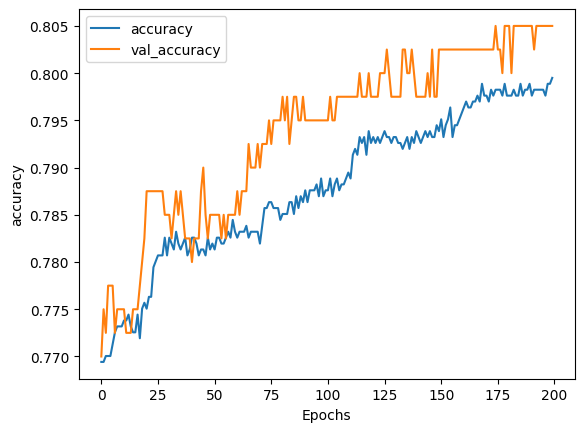

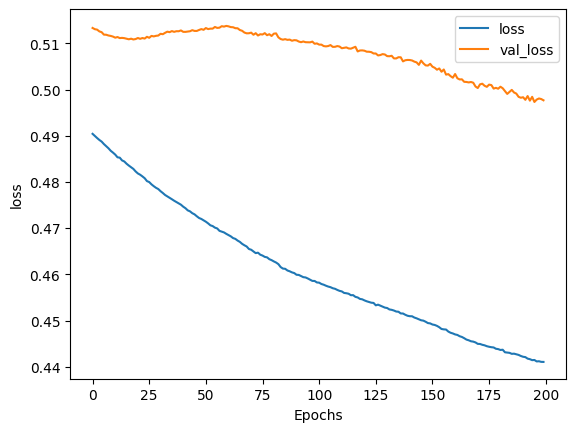

In [41]:
# Evaluate the model on the testing dataset
loss, accuracy = model.evaluate(x_test, y_test)

import matplotlib.pyplot as plt

# Plot utility
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

# Plot the accuracy and loss
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [42]:
### Gated Recurrent Unit (GRU) Model
#--------------------------------------------------------

In [31]:
from tensorflow.keras.layers import GRU

In [32]:


# Model Definition with GRU
# model = Sequential([
#     GRU(64, input_shape=(x_train.shape[1], x_train.shape[2])),
#     Dense(64, activation='relu'),
#     Dense(1, activation='sigmoid')
# ])

# Model Definition with GRU
model = Sequential([
    Bidirectional(GRU(64, input_shape=(x_train.shape[1], x_train.shape[2]))),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Set the training parameters
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])



In [36]:
epochs = 150

# Train the LSTM model
history = model.fit(x_train, y_train, epochs= epochs, batch_size=32, validation_data=(x_test, y_test), verbose=2, shuffle=False)
# history = model.fit(x_train, y_train, epochs= epochs, batch_size=32, validation_data=(x_test, y_test), verbose=2, shuffle=False,  callbacks=[reduce_lr, checkpoint, early_stop])

# Predictions
predictions = model.predict(x_test)
predictions = (predictions > 0.5).astype(int)

# Printing metrics
from sklearn.metrics import classification_report
print(classification_report(y_test, predictions))

Epoch 1/150
50/50 - 0s - loss: 0.6545 - accuracy: 0.5996 - val_loss: 0.6621 - val_accuracy: 0.5625 - 87ms/epoch - 2ms/step
Epoch 2/150
50/50 - 0s - loss: 0.6537 - accuracy: 0.6053 - val_loss: 0.6617 - val_accuracy: 0.5575 - 72ms/epoch - 1ms/step
Epoch 3/150
50/50 - 0s - loss: 0.6534 - accuracy: 0.6059 - val_loss: 0.6619 - val_accuracy: 0.5550 - 72ms/epoch - 1ms/step
Epoch 4/150
50/50 - 0s - loss: 0.6527 - accuracy: 0.6078 - val_loss: 0.6609 - val_accuracy: 0.5550 - 64ms/epoch - 1ms/step
Epoch 5/150
50/50 - 0s - loss: 0.6520 - accuracy: 0.6078 - val_loss: 0.6604 - val_accuracy: 0.5500 - 64ms/epoch - 1ms/step
Epoch 6/150
50/50 - 0s - loss: 0.6513 - accuracy: 0.6078 - val_loss: 0.6598 - val_accuracy: 0.5475 - 65ms/epoch - 1ms/step
Epoch 7/150
50/50 - 0s - loss: 0.6504 - accuracy: 0.6115 - val_loss: 0.6591 - val_accuracy: 0.5425 - 75ms/epoch - 2ms/step
Epoch 8/150
50/50 - 0s - loss: 0.6498 - accuracy: 0.6096 - val_loss: 0.6584 - val_accuracy: 0.5450 - 65ms/epoch - 1ms/step
Epoch 9/150
50/5

In [37]:
# Print the model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_2 (Bidirecti  (None, 128)               27264     
 onal)                                                           
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 35585 (139.00 KB)
Trainable params: 35585 (139.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


13/13 [==============================] - 0s 583us/step - loss: 0.5136 - accuracy: 0.7700


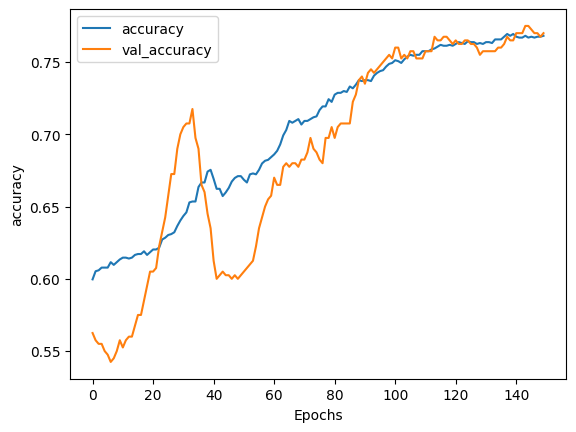

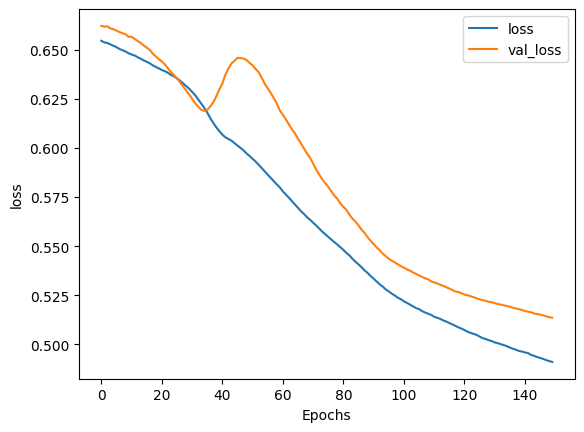

In [38]:
# Evaluate the model on the testing dataset
loss, accuracy = model.evaluate(x_test, y_test)

# Plot the accuracy and loss
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")